In [1]:
from IPython.display import clear_output
!pip install opensimplex
!pip install noise
clear_output()

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import make_grid
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import nibabel as nib
from skimage.transform import resize
from tqdm import tqdm
from opensimplex import OpenSimplex
from skimage.filters import threshold_otsu
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize, Resize

from scipy.ndimage import zoom
from noise import snoise2
from tqdm import tqdm
from torchmetrics.functional import structural_similarity_index_measure as ssim
import random
from torch.optim.lr_scheduler import StepLR


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


np.random.seed(42)

cuda


In [4]:
class XIT2Dataset(Dataset):
    def __init__(self, data_dir, mask_dir=None, transform=None, target_size=(256, 256), noise_type=None, device='cuda'):
        self.data_dir = data_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.target_size = target_size
        self.noise_type = noise_type
        self.device = device

        self.image_paths = self._load_image_paths()
        if mask_dir is not None:
            self.noise_masks = self._load_noise_masks()
        else :
            self.simplex = OpenSimplex(seed=42)
            self.noise_masks = self._generate_noise_masks(100)

    def _load_image_paths(self):
        image_paths = []
        for root, _, files in os.walk(self.data_dir):
            for file in files:
                if file.endswith(".png"):
                    image_paths.append(os.path.join(root, file))
        return sorted(image_paths)

    def _generate_noise_masks(self, num_masks):
        noise_masks = []
        for _ in tqdm(range(num_masks), desc="Generating noise masks"):
            noise_mask = self._generate_simplex_noise_mask()
            noise_masks.append(noise_mask.to(self.device))  
        return noise_masks


    def _generate_simplex_noise_mask(self):
        height, width = self.target_size
        frequency = 2 ** -6
        octaves = 6
        persistence = 0.8
        lacunarity = 2.0
    
        noise = torch.zeros((height, width), device=self.device)  
    
        for octave in range(octaves):
            freq = frequency * (lacunarity ** octave)
            for i in range(height):
                for j in range(width):
                    noise_value = self.simplex.noise2(i * freq, j * freq)
                    noise[i, j] += persistence ** octave * noise_value 
    
        noise = (noise - noise.min()) / (noise.max() - noise.min())
        return noise
    
    def _load_noise_masks(self):
        mask_paths = []
        for root, _, files in os.walk(self.mask_dir):
            for file in files:
                if file.endswith(".png"):
                    mask_paths.append(os.path.join(root, file))
        mask_paths = sorted(mask_paths)
        
        noise_masks = []
        for mask_path in mask_paths:
            mask = Image.open(mask_path).convert("L")  
            mask = self.transform(mask)  
            mask = mask.to(self.device)
            noise_masks.append(mask)
    
        return noise_masks


    def __len__(self):
        return len(self.image_paths)

    def set_noise_type(self, noise_type):
        self.noise_type = noise_type

    def _add_coarse_noise(self, image_tensor):
        batch_size, height, width = image_tensor.shape
        coarse_resolution = (16, 16)
        noise = torch.normal(mean=0.0, std=0.2, size=(batch_size, *coarse_resolution), device=image_tensor.device)
        noise = torch.nn.functional.interpolate(noise.unsqueeze(1), size=(height, width), mode='bilinear', align_corners=False)
        noise = noise.squeeze(1)
        return torch.clamp(image_tensor + noise, -1, 1)

    def _add_simplex_noise(self, image_tensor):
        idx = torch.randint(0, len(self.noise_masks), (1,)).item()
        noise_mask = self.noise_masks[idx]
        image_tensor = image_tensor.to(self.device)
        image_tensor = torch.clamp(image_tensor + noise_mask, -1, 1)
        return image_tensor

    def _add_noise(self, image_tensor):
        if self.noise_type == "coarse":
            return self._add_coarse_noise(image_tensor)
        elif self.noise_type == "simplex":
            return self._add_simplex_noise(image_tensor)
        return image_tensor
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("L")
        image = self.transform(image)
        if self.noise_type:
            image = self._add_noise(image)
        label = torch.tensor(0, dtype=torch.long)
        return image, label

    def plot_samples(self, num_samples=8, label_title='Healthy'):
        if num_samples % 4 != 0:
            raise ValueError("Number of samples must be a multiple of 4.")
        fig, axes = plt.subplots(1, num_samples, figsize=(15, 10))
        for i in range(num_samples):
            idx = np.random.randint(len(self.image_paths))
            image, label = self[idx]
            image_np = image.squeeze(0).cpu().numpy()
            axes[i].imshow(image_np, cmap='gray')
            axes[i].set_title(f"Label: {label_title}")
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()


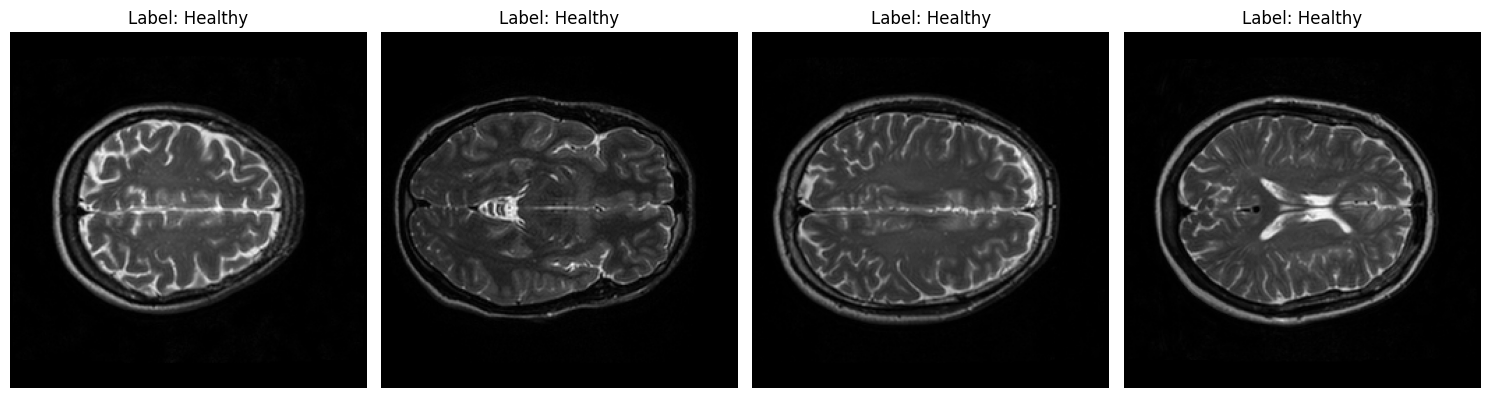

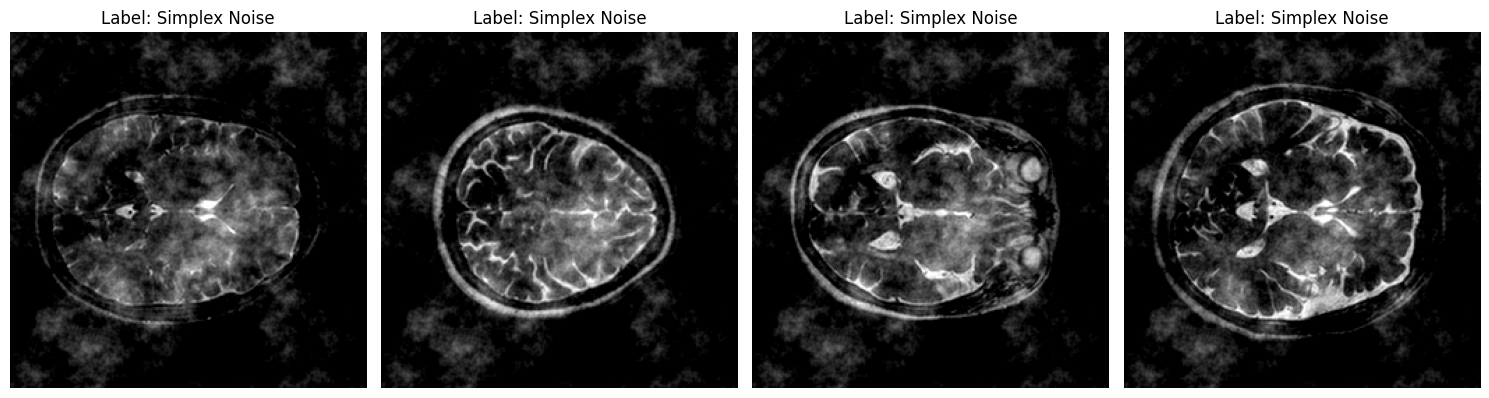

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

ixit1 = XIT2Dataset("/kaggle/input/ixit2-slices", "/kaggle/input/simplex-masks", transform=transform, device=device)
idx = np.random.randint(len(ixit1.image_paths))
ixit1.plot_samples(4, label_title='Healthy')
ixit1.set_noise_type("simplex")
ixit1.plot_samples(4, label_title='Simplex Noise')

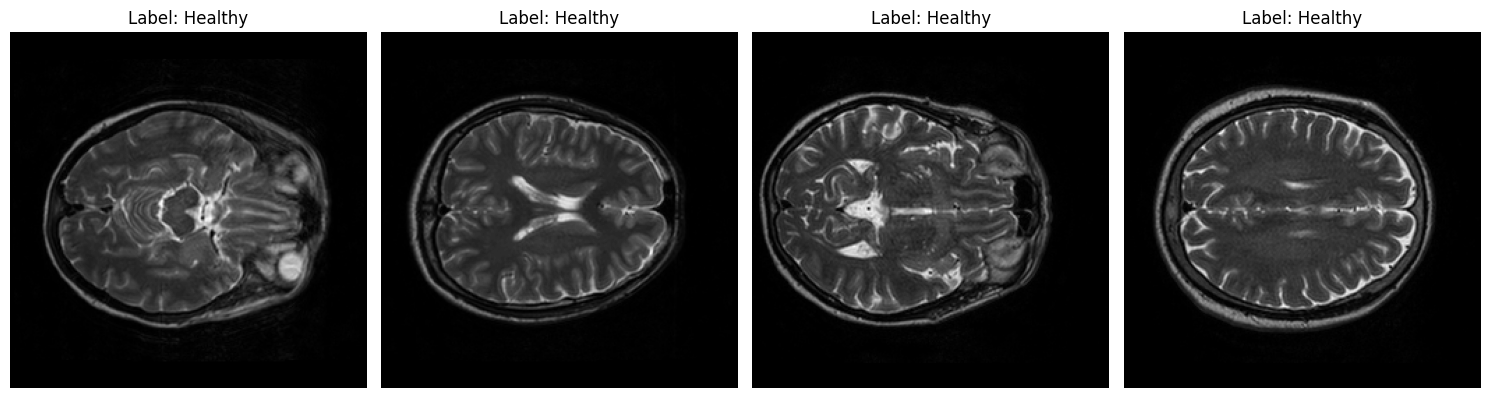

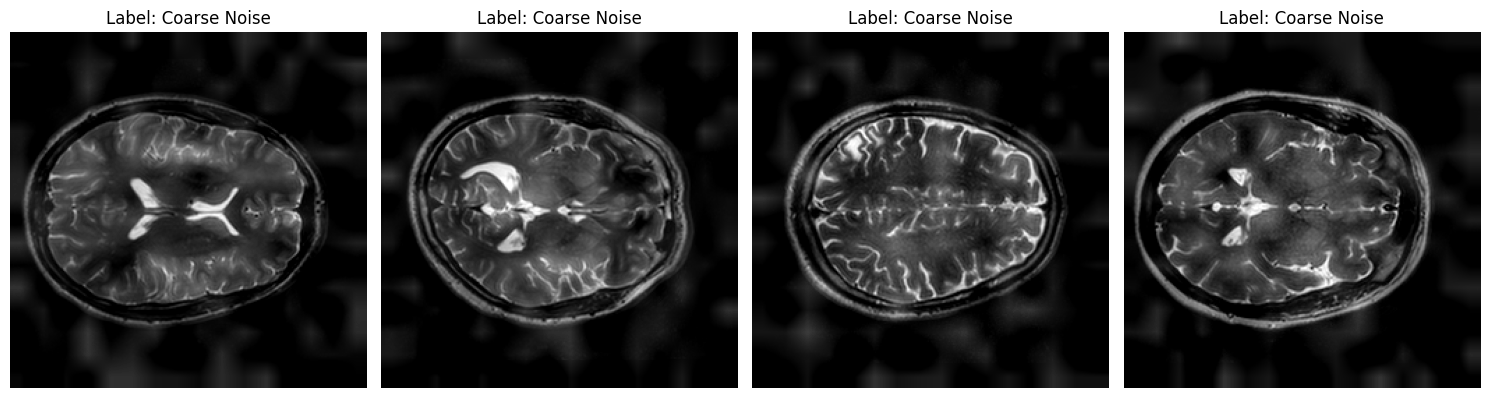

In [6]:
ixit2 = XIT2Dataset("/kaggle/input/ixit2-slices", "/kaggle/input/simplex-masks", transform=transform, device=device)
ixit2.plot_samples(4, label_title='Healthy')
ixit2.set_noise_type("coarse")
ixit2.plot_samples(4, label_title='Coarse Noise')

In [7]:
batch_size = 16
latent_dim = 128
learning_rate = 1e-4
num_epochs = 20

ixit1.set_noise_type(None)
train_loader = DataLoader(ixit1, batch_size=batch_size, shuffle=True)
pos_loader = DataLoader(ixit1, batch_size=batch_size, shuffle=True)
neg_loader = DataLoader(ixit1, batch_size=batch_size, shuffle=True)

In [8]:
class BraTSDataset(Dataset):
    def __init__(self, data_dir, transform=None, target_size=(256, 256)):
        self.data_dir = data_dir
        self.transform = transform
        self.target_size = target_size
        self.image_paths, self.mask_paths = self._load_paths()
    
    def _load_paths(self):
        image_paths = []
        mask_paths = []
        for root, _, files in os.walk(self.data_dir):
            for file in files:
                if file.endswith("_t2.nii"):
                    image_paths.append(os.path.join(root, file))
                    mask_paths.append(os.path.join(root, file.replace("_t2.nii", "_seg.nii")))
        return sorted(image_paths), sorted(mask_paths)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        
        image = nib.load(image_path).get_fdata()
        mask = nib.load(mask_path).get_fdata()
        
        z_index = image.shape[-1] // 2
        image = image[:, :, z_index]  
        mask = mask[:, :, z_index]   
    
        image = (image - np.min(image)) / (np.max(image) - np.min(image))
        image = resize(image, self.target_size, order=1, mode='reflect', anti_aliasing=True)
        mask = resize(mask, self.target_size, order=0, mode='reflect', anti_aliasing=False)
    
        image = Image.fromarray((image * 255).astype(np.uint8))
        mask = Image.fromarray((mask * 255).astype(np.uint8))
    
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        else: # Convert to tensors
            image = torch.tensor(np.array(image), dtype=torch.float32).unsqueeze(0)  # Add channel dim
            mask = torch.tensor(np.array(mask), dtype=torch.float32)
    
        return image, mask

    def plot_samples(self, num_samples=4):
        if num_samples % 2 != 0:
            raise ValueError("Number of samples must be even.")        
        fig, axes = plt.subplots(2, num_samples, figsize=(15, 5))
        for i in range(num_samples):
            idx = np.random.randint(len(self.image_paths))
            image, mask = self[idx]
            image_np = image.squeeze(0).numpy() if isinstance(image, torch.Tensor) else image
            mask_np = mask.squeeze(0).numpy() if len(mask.shape) == 3 else mask
            axes[0, i].imshow(image_np, cmap='gray')
            axes[0, i].set_title("T2 Image")
            axes[0, i].axis('off')
            axes[1, i].imshow(mask_np, cmap='gray')
            axes[1, i].set_title("Segmentation Mask")
            axes[1, i].axis('off')
        plt.tight_layout()
        plt.show()

In [9]:
def dice_coefficient(predicted_mask, ground_truth_mask):
    smooth = 1e-6  
    predicted_mask = predicted_mask.flatten()
    ground_truth_mask = ground_truth_mask.flatten()
    intersection = (predicted_mask * ground_truth_mask).sum()
    return (2. * intersection + smooth) / (predicted_mask.sum() + ground_truth_mask.sum() + smooth)


In [10]:
data_dir = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
brats_dataset = BraTSDataset(data_dir=data_dir, transform=transform)

In [11]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

In [12]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.norm = nn.GroupNorm(8, out_channels)
        self.activation = nn.SiLU()

    def forward(self, x):
        return self.activation(self.norm(self.conv(x)))

In [13]:
class FeatureInteractionModule(nn.Module):
    def __init__(self, encoder_channels, decoder_channels, reduction_ratio=4):
        super(FeatureInteractionModule, self).__init__()
        reduced_channels = encoder_channels // reduction_ratio
        
        self.encoder_conv = nn.Conv2d(encoder_channels, reduced_channels, kernel_size=1)
        self.decoder_conv = nn.Conv2d(decoder_channels, reduced_channels, kernel_size=1)
        
        self.tanh = nn.Tanh()
        self.alpha = nn.Parameter(torch.ones(1))
        self.beta = nn.Parameter(torch.ones(1))
    
    def forward(self, encoder_features, decoder_features):
        reduced_encoder = self.encoder_conv(encoder_features)
        reduced_decoder = self.decoder_conv(decoder_features)
        
        tanh_output = self.tanh(reduced_encoder * reduced_decoder)
        x = tanh_output * reduced_encoder
        output = self.alpha * x + self.beta * reduced_encoder
        
        return output

In [14]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.el1conv1 = ConvBlock(1, 16)
        self.el1conv2 = ConvBlock(16, 16)
        self.el1avgpool = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

        self.el2conv1 = ConvBlock(16, 32)
        self.el2conv2 = ConvBlock(32, 32)
        self.el2avgpool = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

        self.el3conv1 = ConvBlock(32, 64)
        self.el3conv2 = ConvBlock(64, 64)
        self.el3avgpool = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

        self.el4conv1 = ConvBlock(64, 128)
        self.el4conv2 = ConvBlock(128, 128)
        self.el4avgpool = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

        self.el5conv1 = ConvBlock(128, 256)
        self.el5conv2 = ConvBlock(256, 256)
        self.el5avgpool = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

        self.el6conv1 = ConvBlock(256, 512)
        self.el6conv2 = ConvBlock(512, 512)

        self.fc_mu = nn.Linear(512 * 8 * 8, 128)
        self.fc_logvar = nn.Linear(512 * 8 * 8, 128)
        self.fc_decode = nn.Linear(128, 512 * 8 * 8)

        self.dl6upconv =  nn.ConvTranspose2d(1024, 256, kernel_size=2, stride=2)       
        
        self.dl5conv1 = ConvBlock(256, 256)
        self.dl5conv2 = ConvBlock(256, 256)
        self.dl5upconv =  nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)

        self.dl4conv1 = ConvBlock(128, 128)
        self.dl4conv2 = ConvBlock(128, 128)
        self.dl4conv3 = ConvBlock(128, 128)
        self.dl4conv4 = ConvBlock(128, 128)
        self.dl4conv5 = nn.Conv2d(128, 1, 1, 1, 0)
        self.dl4upconv =  nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

        self.dl3conv1 = ConvBlock(64, 64)
        self.dl3conv2 = ConvBlock(64, 64)
        self.dl3upconv =  nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)

        self.dl2conv1 = ConvBlock(32, 32)
        self.dl2conv2 = ConvBlock(32, 32)
        self.dl2upconv =  nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)

        self.dl1conv1 = ConvBlock(16, 16)
        self.dl1conv2 = ConvBlock(16, 16)
        self.dl1conv3 = nn.Conv2d(16, 1, 1, 1, 0)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):

        x = self.el1conv1(x)
        x = self.el1conv2(x)
        skip1 = x
        x = self.el1avgpool(x)

        x = self.el2conv1(x)
        x = self.el2conv2(x)
        skip2 = x
        x = self.el2avgpool(x)

        x = self.el3conv1(x)
        x = self.el3conv2(x)
        skip3 = x
        x = self.el3avgpool(x)

        x = self.el4conv1(x)
        x = self.el4conv2(x)
        x = self.el4avgpool(x)

        x = self.el5conv1(x)
        x = self.el5conv2(x)
        x = self.el5avgpool(x)

        x = self.el6conv1(x)
        x = self.el6conv2(x)
        skip4 = x

        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        z = self.reparameterize(mu, logvar)
        x = self.fc_decode(z)
        x = x.view(x.size(0), 512, 8, 8)
                
        x = self.dl6upconv(torch.cat([x, skip4], dim=1))

        x = self.dl5conv1(x)        
        x = self.dl5conv2(x)        
        x = self.dl5upconv(x)

        x = self.dl4conv1(x)
        x = self.dl4conv2(x)
        ux = self.dl4upconv(x)
        x = self.dl4conv3(x)
        x = self.dl4conv4(x)
        l4out = self.dl4conv5(x)


        x = self.dl3conv1(ux)
        x = self.dl3conv2(x)
        x = self.dl3upconv(x)


        x = self.dl2conv1(x)
        x = self.dl2conv2(x)
        x = self.dl2upconv(x)


        x = self.dl1conv1(x)
        x = self.dl1conv2(x)
        x = self.dl1conv3(x)
        
        return x, l4out, mu, logvar

In [15]:
def plot_training_losses(loss_history):
    epochs = range(1, len(loss_history) + 1)
    plt.plot(epochs, loss_history, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Losses over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

In [16]:
def train_vae(model, dataloader, device, epochs=10, learning_rate=1e-4, alpha=1, beta=1):

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_history = []

    def kld_loss(mu, logvar):
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / mu.size(0)

    def ssim_loss(pred, target):
        return 1 - ssim(pred, target, data_range=1.0)

    model.to(device)
    model.train()

    for epoch in range(epochs):
        epoch_loss = 0
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch")

        for images, _ in progress_bar:  
            images = images.to(device)

            reconstructed, l4_out, mu, logvar = model(images)

            l4_target = nn.functional.interpolate(images, size=(32, 32), mode='bilinear', align_corners=False)

            l1_loss_main = nn.L1Loss()(reconstructed, images)
            l1_loss_l4 = nn.L1Loss()(l4_out, l4_target)
            kld = kld_loss(mu, logvar)
            ssim_value = ssim_loss(reconstructed, images)

            total_loss = l1_loss_main + l1_loss_l4 + kld + ssim_value

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            epoch_loss += total_loss.item()

            progress_bar.set_postfix({"Loss": total_loss.item()})

        avg_epoch_loss = epoch_loss / len(dataloader)
        loss_history.append(avg_epoch_loss)

        print(f"Epoch [{epoch + 1}/{epochs}], Avg Loss: {avg_epoch_loss:.4f}")

    return loss_history


In [17]:
vae = VAE().to(device)
train_losses = train_vae(vae, train_loader, device, epochs = 20)

Epoch 1/20:   0%|          | 0/1804 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(
Epoch 1/20: 100%|██████████| 1804/1804 [05:50<00:00,  5.14batch/s, Loss=0.534]


Epoch [1/20], Avg Loss: 0.7142


Epoch 2/20: 100%|██████████| 1804/1804 [04:03<00:00,  7.40batch/s, Loss=0.481]


Epoch [2/20], Avg Loss: 0.4844


Epoch 3/20: 100%|██████████| 1804/1804 [04:02<00:00,  7.45batch/s, Loss=0.428]


Epoch [3/20], Avg Loss: 0.4140


Epoch 4/20: 100%|██████████| 1804/1804 [04:02<00:00,  7.44batch/s, Loss=0.38]


Epoch [4/20], Avg Loss: 0.3875


Epoch 5/20: 100%|██████████| 1804/1804 [04:02<00:00,  7.45batch/s, Loss=0.364]


Epoch [5/20], Avg Loss: 0.3711


Epoch 6/20: 100%|██████████| 1804/1804 [04:02<00:00,  7.43batch/s, Loss=0.3]


Epoch [6/20], Avg Loss: 0.3589


Epoch 7/20: 100%|██████████| 1804/1804 [04:02<00:00,  7.44batch/s, Loss=0.418]


Epoch [7/20], Avg Loss: 0.3482


Epoch 8/20: 100%|██████████| 1804/1804 [04:02<00:00,  7.45batch/s, Loss=0.331]


Epoch [8/20], Avg Loss: 0.3386


Epoch 9/20: 100%|██████████| 1804/1804 [04:03<00:00,  7.41batch/s, Loss=0.295]


Epoch [9/20], Avg Loss: 0.3282


Epoch 10/20: 100%|██████████| 1804/1804 [04:03<00:00,  7.41batch/s, Loss=0.339]


Epoch [10/20], Avg Loss: 0.3196


Epoch 11/20: 100%|██████████| 1804/1804 [04:02<00:00,  7.43batch/s, Loss=0.355]


Epoch [11/20], Avg Loss: 0.3119


Epoch 12/20: 100%|██████████| 1804/1804 [04:01<00:00,  7.46batch/s, Loss=0.276]


Epoch [12/20], Avg Loss: 0.3046


Epoch 13/20: 100%|██████████| 1804/1804 [04:03<00:00,  7.41batch/s, Loss=0.305]


Epoch [13/20], Avg Loss: 0.2980


Epoch 14/20: 100%|██████████| 1804/1804 [04:04<00:00,  7.38batch/s, Loss=0.278]


Epoch [14/20], Avg Loss: 0.2923


Epoch 15/20: 100%|██████████| 1804/1804 [04:02<00:00,  7.44batch/s, Loss=0.248]


Epoch [15/20], Avg Loss: 0.2867


Epoch 16/20: 100%|██████████| 1804/1804 [04:07<00:00,  7.30batch/s, Loss=0.309]


Epoch [16/20], Avg Loss: 0.2816


Epoch 17/20: 100%|██████████| 1804/1804 [04:01<00:00,  7.48batch/s, Loss=0.24]


Epoch [17/20], Avg Loss: 0.2764


Epoch 18/20: 100%|██████████| 1804/1804 [04:00<00:00,  7.50batch/s, Loss=0.28]


Epoch [18/20], Avg Loss: 0.2715


Epoch 19/20: 100%|██████████| 1804/1804 [03:59<00:00,  7.53batch/s, Loss=0.253]


Epoch [19/20], Avg Loss: 0.2666


Epoch 20/20: 100%|██████████| 1804/1804 [04:00<00:00,  7.50batch/s, Loss=0.298]

Epoch [20/20], Avg Loss: 0.2621


In [18]:
def plot_random_results_vae(vae, dataset, threshold=0.1, num_samples=4):
    vae.eval()
    dice_scores = []
    
    random_indices = random.sample(range(len(dataset)), num_samples)
    
    for idx in random_indices:
        image, ground_truth_mask = dataset[idx]
        image = image.to(device).unsqueeze(0)  

        with torch.no_grad():
            reconstruction, _, _, _ = vae(image)
        
        residual = torch.abs(image - reconstruction)  
        
        predicted_mask = (residual > threshold).float()  
        
        plt.figure(figsize=(20, 5))
        
        plt.subplot(1, 5, 1)
        plt.imshow(image.squeeze().cpu().numpy(), cmap='gray')  
        plt.title("Original Image")
        plt.axis('off')
        
        plt.subplot(1, 5, 2)
        plt.imshow(reconstruction.squeeze().cpu().numpy(), cmap='gray')  
        plt.title("Reconstructed Image")
        plt.axis('off')
        
        plt.subplot(1, 5, 3)
        plt.imshow(residual.squeeze().cpu().numpy(), cmap='gray')  
        plt.title("Residual Image")
        plt.axis('off')
        
        plt.subplot(1, 5, 4)
        plt.imshow(predicted_mask.squeeze().cpu().numpy(), cmap='gray')  
        plt.axis('off')
        
        plt.subplot(1, 5, 5)
        plt.imshow(ground_truth_mask.squeeze().cpu().numpy(), cmap='gray')  
        plt.title("Ground Truth Mask")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()


In [19]:
def calculate_dice(vae, dataset, threshold=0.05):
    vae.eval()
    dice_scores = []
    for i in range(len(dataset)):
        if i == 354 : 
            continue
        image, ground_truth_mask = dataset[i]  
        image = image.to(device).unsqueeze(0) 

        with torch.no_grad():
            reconstruction, _, _, _ = vae(image)

        residual = torch.abs(image - reconstruction)  
        
        predicted_mask = (residual > threshold).float()

        dice = dice_coefficient(
            predicted_mask.squeeze().cpu().numpy(),  
            ground_truth_mask.numpy()
        )
        dice_scores.append(dice)

    avg_dice_score = sum(dice_scores) / len(dice_scores)
    print(f"Average Dice Score: {avg_dice_score:.4f}")


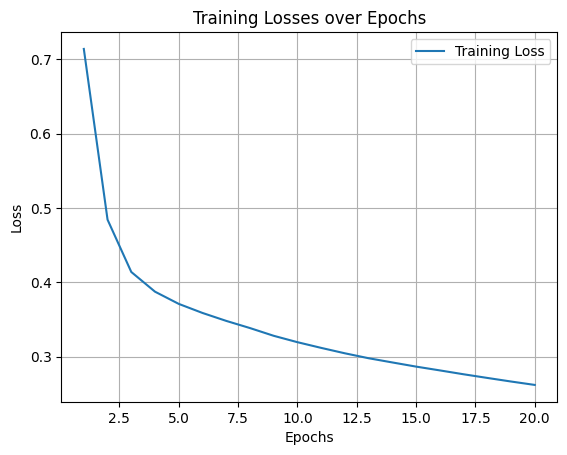

In [20]:
plot_training_losses(train_losses)

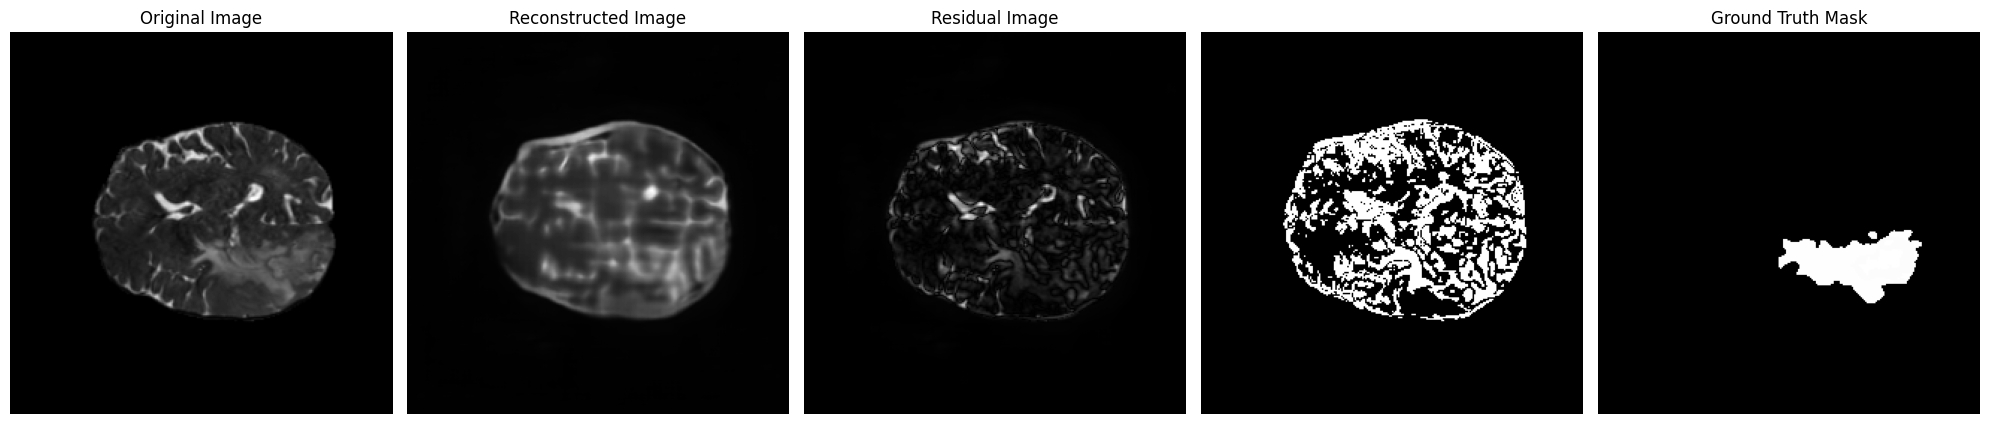

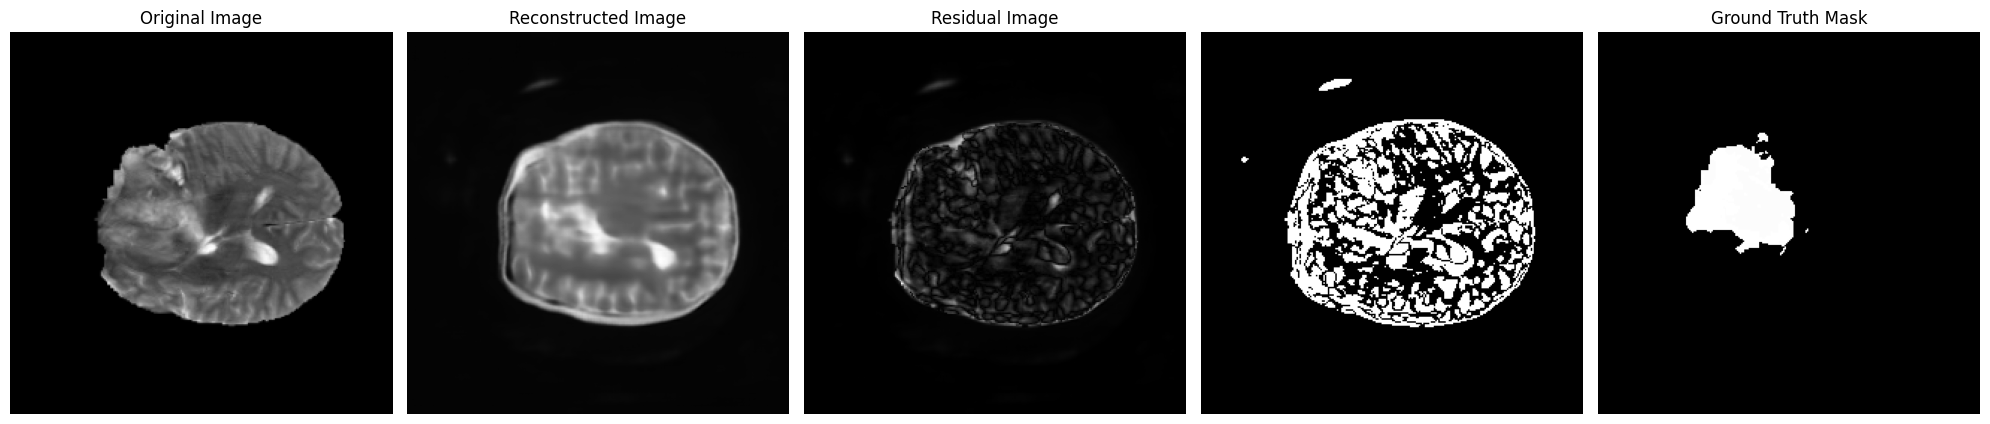

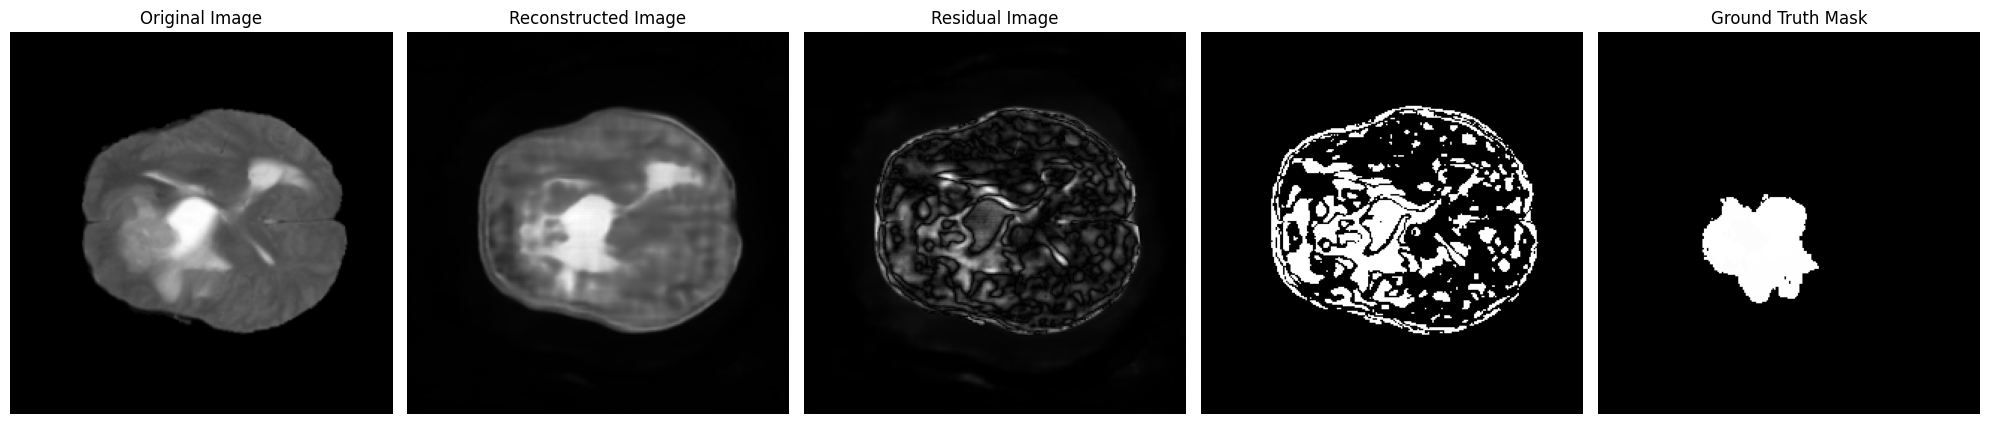

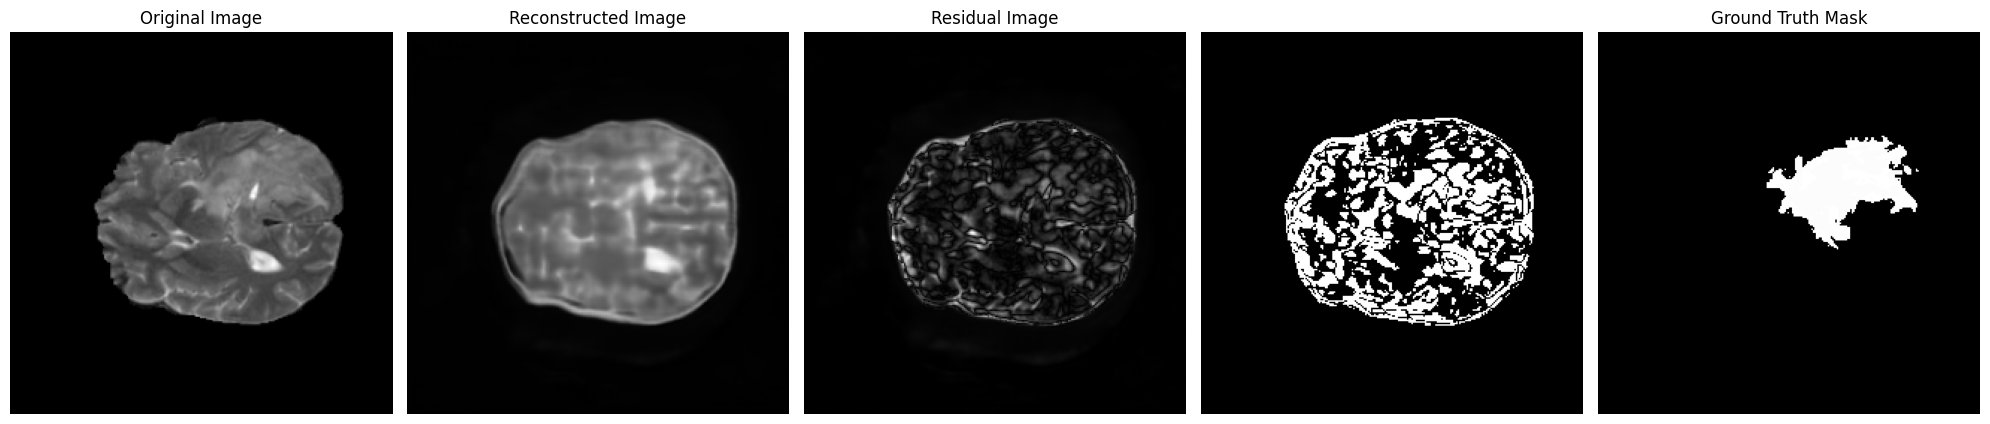

In [21]:
plot_random_results_vae(vae, brats_dataset)

In [22]:
calculate_dice(vae, brats_dataset, 0.1)

Average Dice Score: 0.2878


In [23]:
def train_tri_vae(
    model, 
    anc_dataloader, 
    pos_dataloader, 
    neg_dataloader, 
    dataset,
    device, 
    epochs=20, 
    learning_rate=3e-4, 
    alpha=1, 
    beta=1, 
    patience=3
):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_history = []

    def kld_loss(mu, logvar):
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / mu.size(0)

    def ssim_loss(pred, target):
        return 1 - ssim(pred, target)

    def triplet_loss(anchor_mu, positive_mu, negative_mu, margin=1.0):
        pos_dist = torch.sum((anchor_mu - positive_mu) ** 2, dim=1).mean()
        neg_dist = torch.sum((anchor_mu - negative_mu) ** 2, dim=1).mean()
        return torch.relu(pos_dist - neg_dist + margin)

    model.to(device)
    model.train()

    best_epoch_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        epoch_loss = 0
        progress_bar = tqdm(
            zip(anc_dataloader, pos_dataloader, neg_dataloader),
            desc=f"Epoch {epoch + 1}/{epochs}",
            unit="batch",
            total=len(anc_dataloader)
        )

        for (anc_images, _), (pos_images, _), (neg_images, _) in progress_bar:
            anc_images, pos_images, neg_images = anc_images.to(device), pos_images.to(device), neg_images.to(device)

            noised_negs = torch.stack([dataset._add_coarse_noise(image) for image in neg_images])

            
            anc_reconstructed, anc_l4_out, anc_mu, anc_logvar = model(anc_images)
            pos_reconstructed, pos_l4_out, pos_mu, pos_logvar = model(pos_images)
            neg_reconstructed, neg_l4_out, neg_mu, neg_logvar = model(noised_negs)

            anc_l4_target = nn.functional.interpolate(anc_images, size=(32, 32), mode='bilinear', align_corners=False)
            pos_l4_target = nn.functional.interpolate(pos_images, size=(32, 32), mode='bilinear', align_corners=False)
            neg_l4_target = nn.functional.interpolate(neg_images, size=(32, 32), mode='bilinear', align_corners=False)

            l1_anc32 = nn.L1Loss()(anc_l4_out, anc_l4_target)
            l1_pos32 = nn.L1Loss()(pos_l4_out, pos_l4_target)
            l1_neg32 = nn.L1Loss()(neg_l4_out, neg_l4_target)
            l1_neg256 = nn.L1Loss()(neg_reconstructed, neg_images)

            kld_anc = kld_loss(anc_mu, anc_logvar)
            kld_pos = kld_loss(pos_mu, pos_logvar)

            ssim_neg = ssim_loss(neg_reconstructed, neg_images)

            l_triplet = triplet_loss(anc_mu, pos_mu, neg_mu)

            l1_total = l1_anc32 + l1_pos32 + l1_neg32 + l1_neg256 
            kld_total = kld_anc + kld_pos
            total_loss = l1_total + kld_total + l_triplet + ssim_neg

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            epoch_loss += total_loss.item()
            progress_bar.set_postfix({"Loss": total_loss.item()})

        avg_epoch_loss = epoch_loss / len(anc_dataloader)
        loss_history.append(avg_epoch_loss)
        print(f"Epoch [{epoch + 1}/{epochs}], Avg Loss: {avg_epoch_loss:.4f}")

        if avg_epoch_loss < best_epoch_loss:
            best_epoch_loss = avg_epoch_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_I_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered. Stopping training.")
                model.load_state_dict(torch.load('best_I_model.pth'))
                break

    return loss_history


In [24]:
class Improved_VAE(nn.Module):
    def __init__(self):
        super(Improved_VAE, self).__init__()

        self.el1conv1 = ConvBlock(1, 16)
        self.el1conv2 = ConvBlock(16, 16)
        self.el1avgpool = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

        self.el2conv1 = ConvBlock(16, 32)
        self.el2conv2 = ConvBlock(32, 32)
        self.el2avgpool = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

        self.el3conv1 = ConvBlock(32, 64)
        self.el3conv2 = ConvBlock(64, 64)
        self.el3avgpool = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

        self.el4conv1 = ConvBlock(64, 128)
        self.el4conv2 = ConvBlock(128, 128)
        self.el4avgpool = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

        self.el5conv1 = ConvBlock(128, 256)
        self.el5conv2 = ConvBlock(256, 256)
        self.el5avgpool = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

        self.el6conv1 = ConvBlock(256, 512)
        self.el6conv2 = ConvBlock(512, 512)

        
        self.fc_mu = nn.Linear(512 * 8 * 8, 256)
        self.fc_logvar = nn.Linear(512 * 8 * 8, 256)
        self.fc_decode = nn.Linear(256, 512 * 8 * 8)

        self.dl6upconv =  nn.ConvTranspose2d(1024, 256, kernel_size=2, stride=2)       
        
        self.dl5conv1 = ConvBlock(256, 256)
        self.dl5conv2 = ConvBlock(256, 256)
        self.dl5upconv =  nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)

        self.dl4conv1 = ConvBlock(128, 128)
        self.dl4conv2 = ConvBlock(128, 128)
        self.dl4conv3 = ConvBlock(128, 128)
        self.dl4conv4 = ConvBlock(128, 128)
        self.dl4conv5 = nn.Conv2d(128, 1, 1, 1, 0)
        self.dl4upconv =  nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

        self.dl3conv1 = ConvBlock(80, 64)
        self.dl3conv2 = ConvBlock(64, 64)
        self.dl3upconv =  nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)

        self.dl2conv1 = ConvBlock(40, 32)
        self.dl2conv2 = ConvBlock(32, 32)
        self.dl2upconv =  nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)

        self.dl1conv1 = ConvBlock(20, 16)
        self.dl1conv2 = ConvBlock(16, 16)
        self.dl1conv3 = nn.Conv2d(16, 1, 1, 1, 0)

        self.l1gcs = FeatureInteractionModule(16, 16)
        self.l2gcs = FeatureInteractionModule(32, 32)
        self.l3gcs = FeatureInteractionModule(64, 64)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):

        x = self.el1conv1(x)
        x = self.el1conv2(x)
        skip1 = x
        x = self.el1avgpool(x)

        x = self.el2conv1(x)
        x = self.el2conv2(x)
        skip2 = x
        x = self.el2avgpool(x)

        x = self.el3conv1(x)
        x = self.el3conv2(x)
        skip3 = x
        x = self.el3avgpool(x)

        x = self.el4conv1(x)
        x = self.el4conv2(x)
        x = self.el4avgpool(x)

        x = self.el5conv1(x)
        x = self.el5conv2(x)
        x = self.el5avgpool(x)

        x = self.el6conv1(x)
        x = self.el6conv2(x)
        skip4 = x

        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        z = self.reparameterize(mu, logvar)
        x = self.fc_decode(z)
        x = x.view(x.size(0), 512, 8, 8)
               
        x = self.dl6upconv(torch.cat([x, skip4], dim=1))

        x = self.dl5conv1(x)        
        x = self.dl5conv2(x)        
        x = self.dl5upconv(x)

        x = self.dl4conv1(x)
        x = self.dl4conv2(x)
        ux = self.dl4upconv(x)
        x = self.dl4conv3(x)
        x = self.dl4conv4(x)
        l4out = self.dl4conv5(x)

        l3gcs = self.l3gcs(skip3, ux)

        x = self.dl3conv1(torch.cat([l3gcs, ux], dim=1))
        x = self.dl3conv2(x)
        x = self.dl3upconv(x)

        l2gcs = self.l2gcs(skip2, x)

        x = self.dl2conv1(torch.cat([l2gcs, x], dim=1))
        x = self.dl2conv2(x)
        x = self.dl2upconv(x)

        l1gcs = self.l1gcs(skip1, x)

        x = self.dl1conv1(torch.cat([l1gcs, x], dim=1))
        x = self.dl1conv2(x)
        x = self.dl1conv3(x)
        
        return x, l4out, mu, logvar

In [25]:
I_vae = Improved_VAE().to(device)
# I_vae.load_state_dict(torch.load('/kaggle/input/new-i-vae/best_I_model.pth', weights_only=True))
train_losses = train_tri_vae(I_vae, train_loader, pos_loader, neg_loader, ixit1, device, epochs = 20)

Epoch 1/20: 100%|██████████| 1804/1804 [10:17<00:00,  2.92batch/s, Loss=0.853]


Epoch [1/20], Avg Loss: 3.1245


Epoch 2/20: 100%|██████████| 1804/1804 [10:13<00:00,  2.94batch/s, Loss=0.52]


Epoch [2/20], Avg Loss: 0.4624


Epoch 3/20: 100%|██████████| 1804/1804 [10:13<00:00,  2.94batch/s, Loss=0.565]


Epoch [3/20], Avg Loss: 2.3456


Epoch 4/20: 100%|██████████| 1804/1804 [10:15<00:00,  2.93batch/s, Loss=0.406]


Epoch [4/20], Avg Loss: 0.4465


Epoch 5/20: 100%|██████████| 1804/1804 [10:22<00:00,  2.90batch/s, Loss=0.311]


Epoch [5/20], Avg Loss: 0.4274


Epoch 6/20: 100%|██████████| 1804/1804 [10:22<00:00,  2.90batch/s, Loss=1.2]


Epoch [6/20], Avg Loss: 0.3653


Epoch 7/20: 100%|██████████| 1804/1804 [10:25<00:00,  2.88batch/s, Loss=1.18]


Epoch [7/20], Avg Loss: 0.3199


Epoch 8/20: 100%|██████████| 1804/1804 [10:24<00:00,  2.89batch/s, Loss=0.299]


Epoch [8/20], Avg Loss: 0.3195


Epoch 9/20: 100%|██████████| 1804/1804 [10:30<00:00,  2.86batch/s, Loss=0.898]


Epoch [9/20], Avg Loss: 0.9721


Epoch 10/20: 100%|██████████| 1804/1804 [10:22<00:00,  2.90batch/s, Loss=0.877]


Epoch [10/20], Avg Loss: 0.3141


Epoch 11/20: 100%|██████████| 1804/1804 [10:16<00:00,  2.93batch/s, Loss=0.427]


Epoch [11/20], Avg Loss: 0.3194


Epoch 12/20: 100%|██████████| 1804/1804 [10:16<00:00,  2.93batch/s, Loss=0.315]


Epoch [12/20], Avg Loss: 0.2988


Epoch 13/20: 100%|██████████| 1804/1804 [10:17<00:00,  2.92batch/s, Loss=0.338]


Epoch [13/20], Avg Loss: 0.4444


Epoch 14/20: 100%|██████████| 1804/1804 [10:19<00:00,  2.91batch/s, Loss=0.229]


Epoch [14/20], Avg Loss: 0.2624


Epoch 15/20: 100%|██████████| 1804/1804 [10:18<00:00,  2.92batch/s, Loss=0.226]


Epoch [15/20], Avg Loss: 0.2410


Epoch 16/20: 100%|██████████| 1804/1804 [10:24<00:00,  2.89batch/s, Loss=0.224]


Epoch [16/20], Avg Loss: 0.2424


Epoch 17/20: 100%|██████████| 1804/1804 [10:19<00:00,  2.91batch/s, Loss=0.244]


Epoch [17/20], Avg Loss: 0.2290


Epoch 18/20: 100%|██████████| 1804/1804 [10:18<00:00,  2.91batch/s, Loss=0.264]


Epoch [18/20], Avg Loss: 0.4388


Epoch 19/20: 100%|██████████| 1804/1804 [10:17<00:00,  2.92batch/s, Loss=1.03]


Epoch [19/20], Avg Loss: 0.2358


Epoch 20/20: 100%|██████████| 1804/1804 [10:23<00:00,  2.89batch/s, Loss=0.195]


Epoch [20/20], Avg Loss: 0.2168


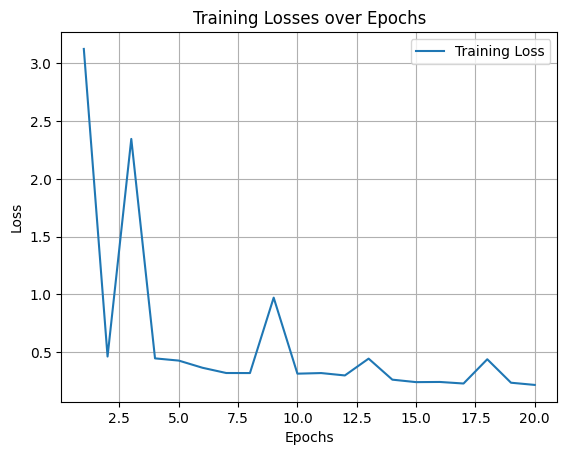

In [26]:
plot_training_losses(train_losses)

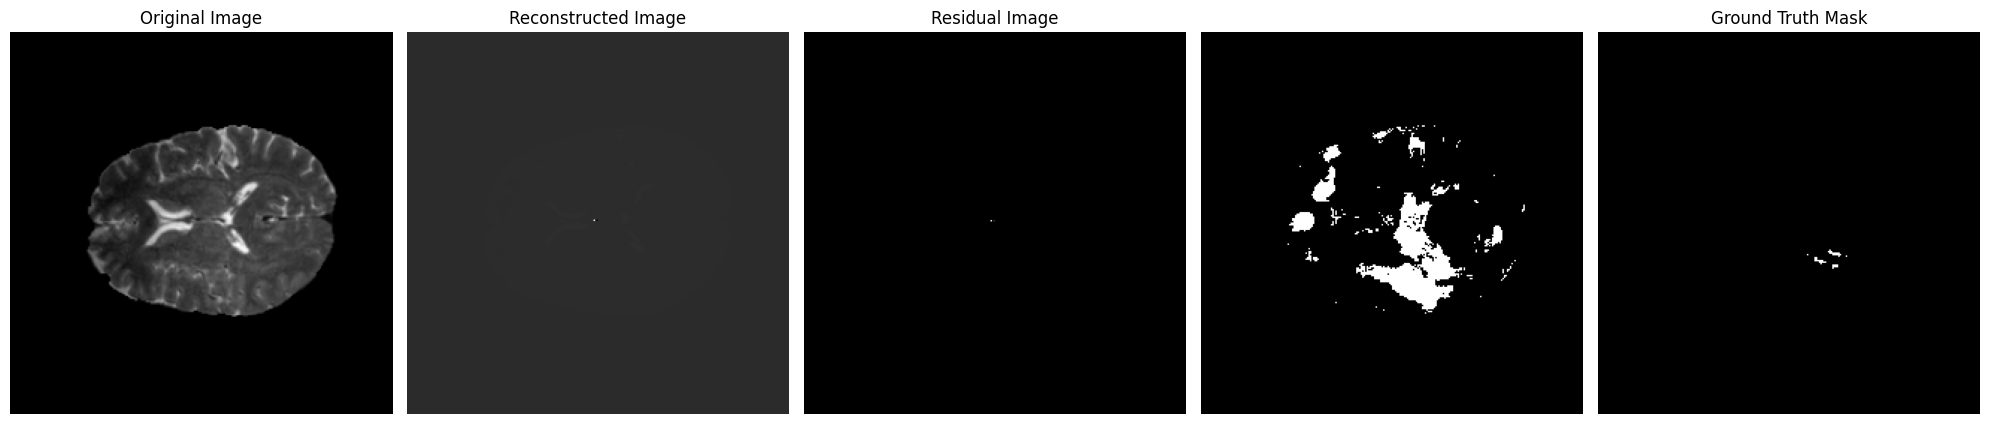

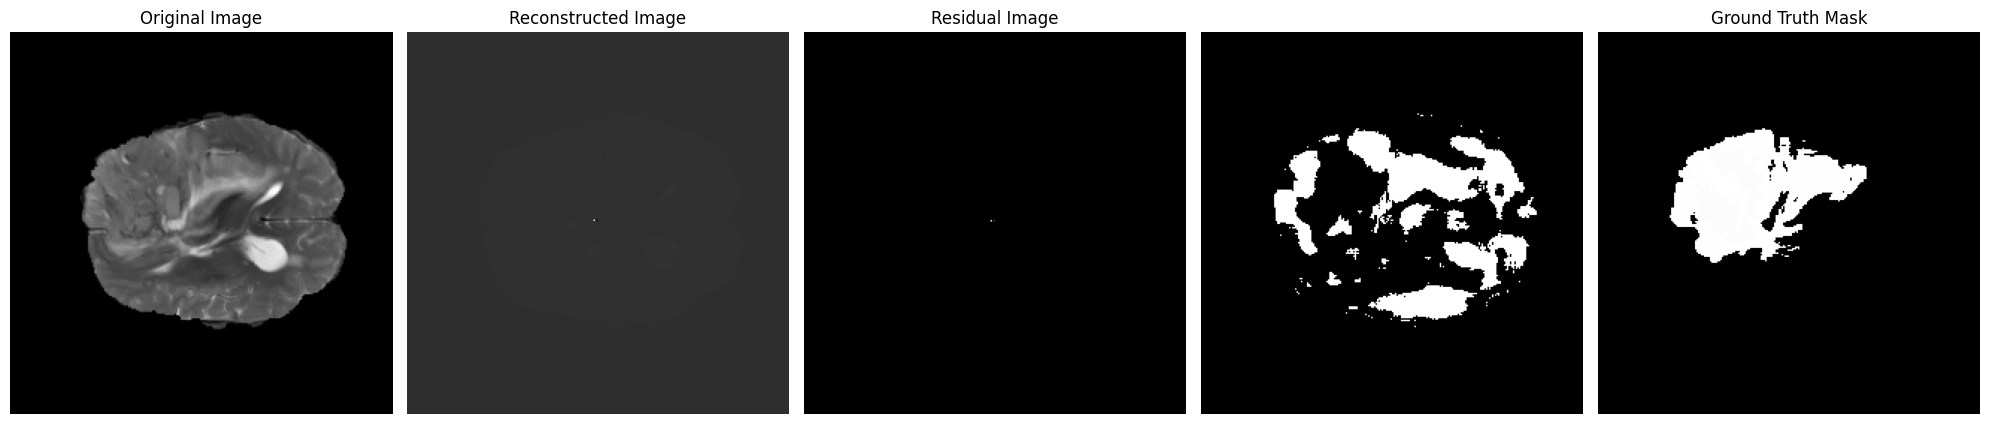

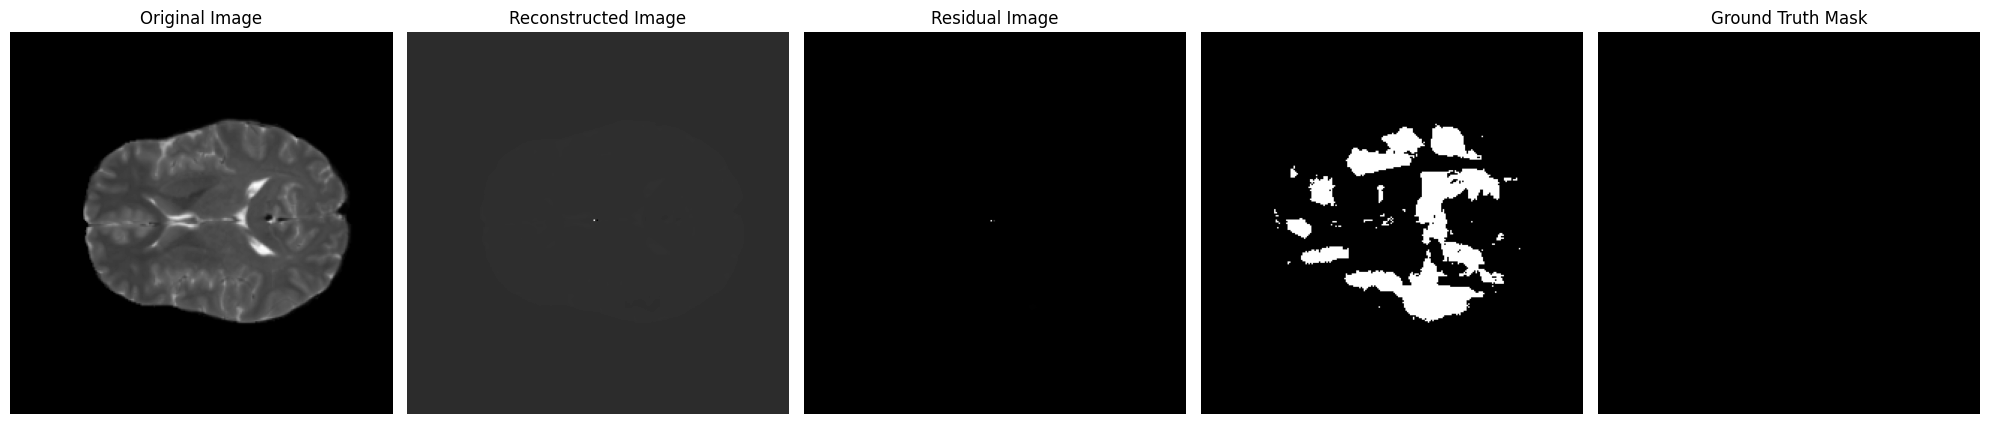

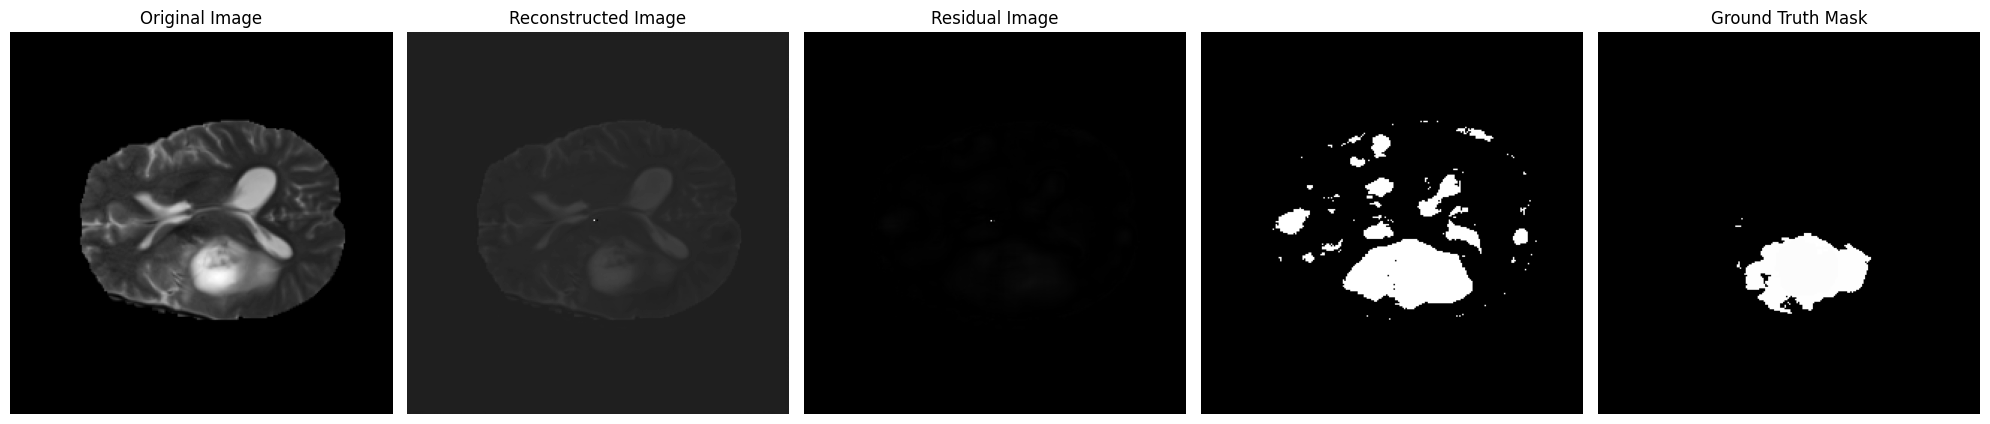

In [27]:
plot_random_results_vae(I_vae, brats_dataset, threshold=0.1)

In [28]:
calculate_dice(I_vae, brats_dataset, 0.1)

Average Dice Score: 0.1257


In [29]:
def train_tri_vae_simplex(
    model, 
    anc_dataloader, 
    pos_dataloader, 
    neg_dataloader, 
    dataset,
    device, 
    epochs=20, 
    learning_rate=3e-4, 
    alpha=1, 
    beta=1, 
    patience=3
):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_history = []

    def kld_loss(mu, logvar):
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / mu.size(0)

    def ssim_loss(pred, target):
        return 1 - ssim(pred, target)

    def triplet_loss(anchor_mu, positive_mu, negative_mu, margin=1.0):
        pos_dist = torch.sum((anchor_mu - positive_mu) ** 2, dim=1).mean()
        neg_dist = torch.sum((anchor_mu - negative_mu) ** 2, dim=1).mean()
        return torch.relu(pos_dist - neg_dist + margin)

    model.to(device)
    model.train()

    best_epoch_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        epoch_loss = 0
        progress_bar = tqdm(
            zip(anc_dataloader, pos_dataloader, neg_dataloader),
            desc=f"Epoch {epoch + 1}/{epochs}",
            unit="batch",
            total=len(anc_dataloader)
        )

        for (anc_images, _), (pos_images, _), (neg_images, _) in progress_bar:
            anc_images, pos_images, neg_images = anc_images.to(device), pos_images.to(device), neg_images.to(device)

            noised_negs = torch.stack([dataset._add_simplex_noise(image) for image in neg_images])

            
            anc_reconstructed, anc_l4_out, anc_mu, anc_logvar = model(anc_images)
            pos_reconstructed, pos_l4_out, pos_mu, pos_logvar = model(pos_images)
            neg_reconstructed, neg_l4_out, neg_mu, neg_logvar = model(noised_negs)

            anc_l4_target = nn.functional.interpolate(anc_images, size=(32, 32), mode='bilinear', align_corners=False)
            pos_l4_target = nn.functional.interpolate(pos_images, size=(32, 32), mode='bilinear', align_corners=False)
            neg_l4_target = nn.functional.interpolate(neg_images, size=(32, 32), mode='bilinear', align_corners=False)

            l1_anc32 = nn.L1Loss()(anc_l4_out, anc_l4_target)
            l1_pos32 = nn.L1Loss()(pos_l4_out, pos_l4_target)
            l1_neg32 = nn.L1Loss()(neg_l4_out, neg_l4_target)
            l1_neg256 = nn.L1Loss()(neg_reconstructed, neg_images)

            kld_anc = kld_loss(anc_mu, anc_logvar)
            kld_pos = kld_loss(pos_mu, pos_logvar)

            ssim_neg = ssim_loss(neg_reconstructed, neg_images)

            l_triplet = triplet_loss(anc_mu, pos_mu, neg_mu)

            l1_total = l1_anc32 + l1_pos32 + l1_neg32 + l1_neg256 
            kld_total = kld_anc + kld_pos
            total_loss = l1_total + kld_total + l_triplet + ssim_neg

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            epoch_loss += total_loss.item()
            progress_bar.set_postfix({"Loss": total_loss.item()})

        avg_epoch_loss = epoch_loss / len(anc_dataloader)
        loss_history.append(avg_epoch_loss)
        print(f"Epoch [{epoch + 1}/{epochs}], Avg Loss: {avg_epoch_loss:.4f}")

        if avg_epoch_loss < best_epoch_loss:
            best_epoch_loss = avg_epoch_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_S_I_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered. Stopping training.")
                model.load_state_dict(torch.load('best_I_model.pth'))
                break

    return loss_history


In [30]:
simplex_I_vae = Improved_VAE().to(device) 
simplex_I_vae.load_state_dict(torch.load('/kaggle/input/new-i-vae/best_S_I_model.pth', weights_only=True))

<All keys matched successfully>

In [31]:
train_losses = train_tri_vae_simplex(simplex_I_vae, train_loader, pos_loader, neg_loader, ixit1, device, epochs = 10)

Epoch 1/10: 100%|██████████| 1804/1804 [10:21<00:00,  2.90batch/s, Loss=0.15]


Epoch [1/10], Avg Loss: 0.1428


Epoch 2/10: 100%|██████████| 1804/1804 [10:24<00:00,  2.89batch/s, Loss=0.127]


Epoch [2/10], Avg Loss: 0.1400


Epoch 3/10: 100%|██████████| 1804/1804 [10:19<00:00,  2.91batch/s, Loss=0.133]


Epoch [3/10], Avg Loss: 0.1378


Epoch 4/10: 100%|██████████| 1804/1804 [10:20<00:00,  2.91batch/s, Loss=0.309]


Epoch [4/10], Avg Loss: 0.3021


Epoch 5/10: 100%|██████████| 1804/1804 [10:27<00:00,  2.87batch/s, Loss=0.197]


Epoch [5/10], Avg Loss: 0.2499


Epoch 6/10: 100%|██████████| 1804/1804 [10:22<00:00,  2.90batch/s, Loss=0.183]
<ipython-input-29-6ed2fd41b4c0>:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_s

Epoch [6/10], Avg Loss: 0.1947
Early stopping triggered. Stopping training.


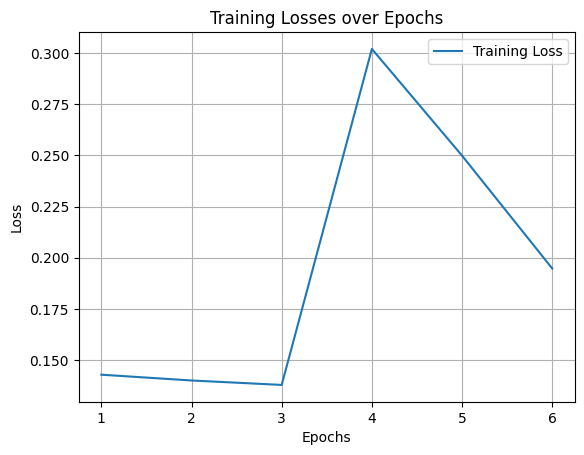

In [32]:
plot_training_losses(train_losses)

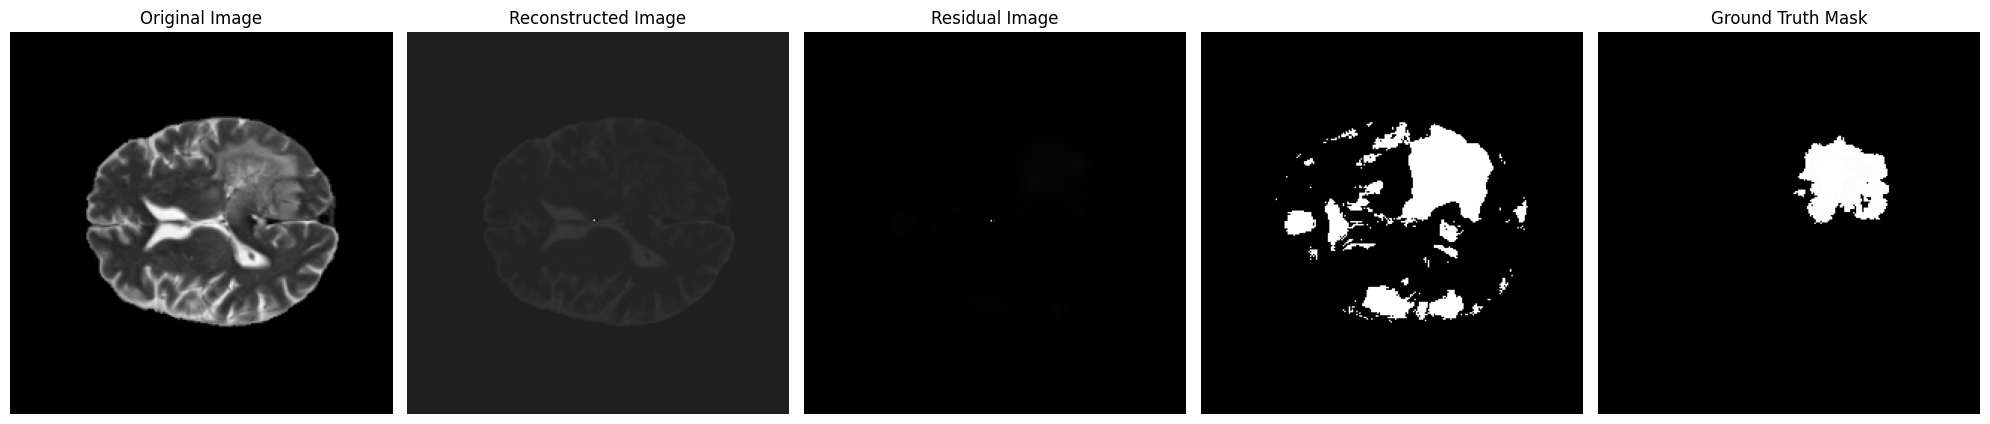

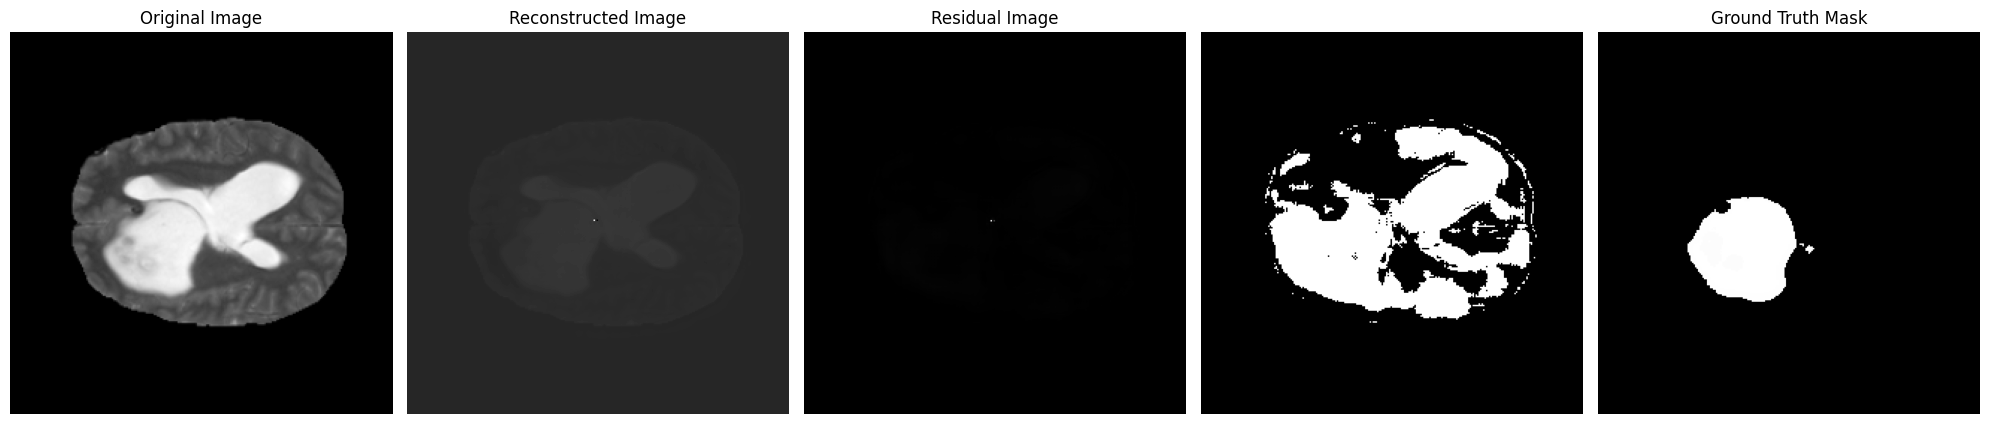

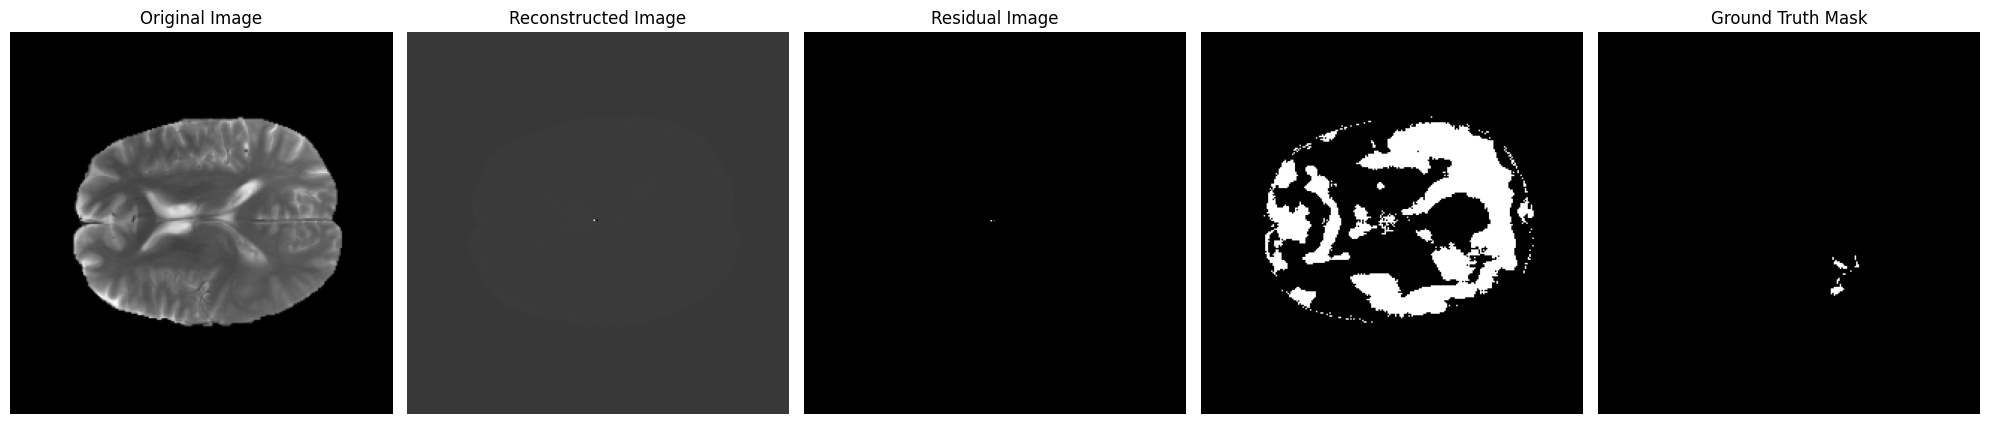

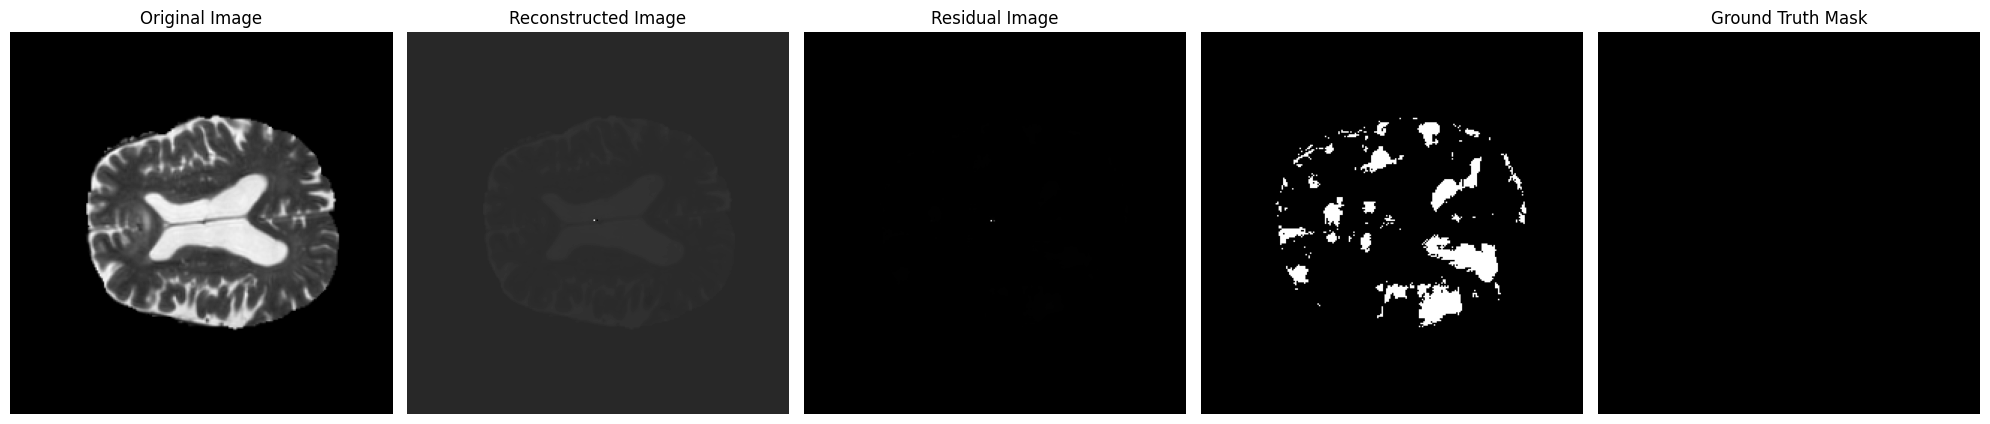

In [33]:
plot_random_results_vae(simplex_I_vae, brats_dataset, threshold=0.1)

In [34]:
calculate_dice(simplex_I_vae, brats_dataset, 0.1)

Average Dice Score: 0.1261
